In [8]:
from tqdm import tqdm

import numpy as np
import scipy.sparse as sp
import torch
from torch_geometric.utils import get_laplacian, dropout_edge
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

In [31]:
adj = torch.Tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
    [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]
]).type(torch.int64)
eps = 1.

laplacian_edge_index, laplacian_edge_weights = get_laplacian(adj)
laplacian = torch.zeros((adj.max()+1, adj.max()+1))
laplacian[laplacian_edge_index[0], laplacian_edge_index[1]] = laplacian_edge_weights
laplacian_pinv = torch.linalg.pinv(laplacian)

laplacian_pinv_diag = torch.diag(laplacian_pinv)
commute_times = adj.size(1) * (laplacian_pinv_diag.unsqueeze(0) + laplacian_pinv_diag.unsqueeze(1) - 2*laplacian_pinv)

commute_times

tensor([[0.0000, 6.0000, 6.0000, 6.0000],
        [6.0000, 0.0000, 6.0000, 6.0000],
        [6.0000, 6.0000, 0.0000, 6.0000],
        [6.0000, 6.0000, 6.0000, 0.0000]])

In [32]:
dataset = TUDataset(root='./data', name='Proteins')
len(dataset)

1113

In [33]:
molecule = dataset[0]

laplacian_edge_index, laplacian_edge_weights = get_laplacian(molecule.edge_index, num_nodes=molecule.num_nodes)
laplacian = torch.zeros((molecule.num_nodes, molecule.num_nodes))
laplacian[laplacian_edge_index[0], laplacian_edge_index[1]] = laplacian_edge_weights

laplacian_pinv = torch.linalg.pinv(laplacian)
laplacian_pinv_diag = torch.diag(laplacian_pinv)
commute_times = molecule.num_edges * (laplacian_pinv_diag.unsqueeze(0) + laplacian_pinv_diag.unsqueeze(1) - 2*laplacian_pinv)

commute_times_flattened = torch.triu(commute_times, diagonal=1).flatten()
commute_times_filtered = commute_times_flattened[commute_times_flattened > 0.]
avg_commute_time = torch.mean(commute_times_filtered)

avg_commute_time

tensor(332.0983)

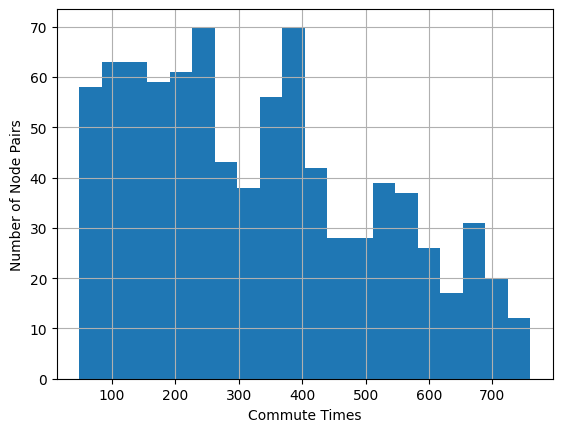

In [34]:
plt.hist(commute_times_filtered, bins=20)
plt.xlabel('Commute Times')
plt.ylabel('Number of Node Pairs')
plt.grid()
plt.show()

In [35]:
avg_commute_times = list()

for molecule in dataset:
    
    laplacian_edge_index, laplacian_edge_weights = get_laplacian(molecule.edge_index, num_nodes=molecule.num_nodes)
    laplacian = torch.zeros((molecule.num_nodes, molecule.num_nodes))
    laplacian[laplacian_edge_index[0], laplacian_edge_index[1]] = laplacian_edge_weights

    laplacian_pinv = torch.linalg.pinv(laplacian)
    laplacian_pinv_diag = torch.diag(laplacian_pinv)
    commute_times = molecule.num_edges * (laplacian_pinv_diag.unsqueeze(0) + laplacian_pinv_diag.unsqueeze(1) - 2*laplacian_pinv)

    commute_times_flattened = torch.triu(commute_times, diagonal=1).flatten()
    commute_times_filtered = commute_times_flattened[commute_times_flattened > 0.]
    avg_commute_time = torch.mean(commute_times_filtered)

    avg_commute_times.append(avg_commute_time)

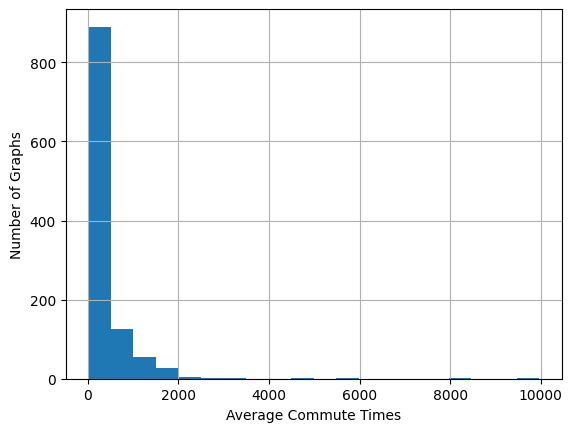

In [36]:
plt.hist(avg_commute_times, bins=20)
plt.xlabel('Average Commute Times')
plt.ylabel('Number of Graphs')
plt.grid()
plt.show()

In [5]:
N_SAMPLES = 10
eps = 1.
avg_commute_times = dict()
mean_all_commute_times = dict()
std_all_commute_times = dict()

for p in np.arange(0.1, 1.0, 0.1):

    avg_commute_times[p] = list()
    all_commute_times = list()

    for _ in tqdm(range(N_SAMPLES)):

        while True:
            try:
                dropped_adj = dropout_edge(dataset.edge_index, p, force_undirected=True)[0]
                laplacian_edge_index, laplacian_edge_weights = get_laplacian(dropped_adj)
                laplacian = torch.zeros((dataset.y.size(0), dataset.y.size(0)))
                laplacian[laplacian_edge_index[0], laplacian_edge_index[1]] = laplacian_edge_weights
                laplacian_pinv = torch.linalg.pinv(laplacian)
                break
            except torch.linalg.LinAlgError:
                continue
        
        laplacian_pinv_diag = torch.diag(laplacian_pinv)
        commute_times = dropped_adj.size(1) * (laplacian_pinv_diag.unsqueeze(0) + laplacian_pinv_diag.unsqueeze(1) - 2*laplacian_pinv)
        
        commute_times_flattened = torch.triu(commute_times+eps, diagonal=1).flatten()
        commute_times_filtered = commute_times_flattened[commute_times_flattened > 0.] - eps
        avg_commute_time = torch.mean(commute_times_filtered)
        
        avg_commute_times[p].append(avg_commute_time)
        all_commute_times.append(commute_times_filtered)

    mean_all_commute_times[p] = torch.mean(torch.stack(all_commute_times), dim=0)
    std_all_commute_times[p] = torch.std(torch.stack(all_commute_times), dim=0)

keys = sorted(mean_all_commute_times.keys())
# mean and std over DropEdge samples, shape (9, |Node Pairs|)
mean_all_commute_times = torch.stack([mean_all_commute_times[key] for key in keys])
std_all_commute_times = torch.stack([std_all_commute_times[key] for key in keys])

# had to force dropping undirected edges beacuse commute time computation using Laplacian inverse is for that case

100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


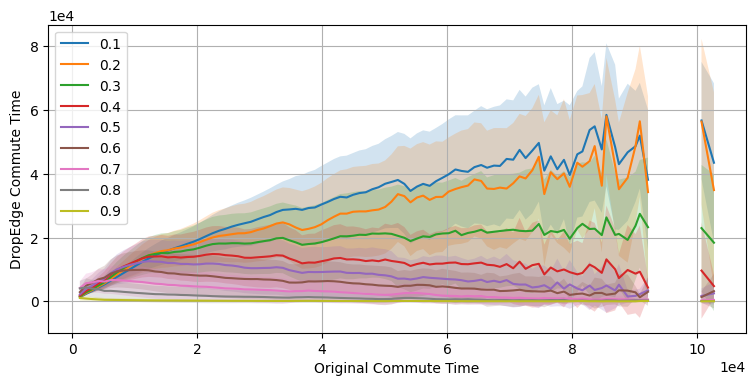

In [6]:
N_BINS = 100
eps = 1e-12

bin_assignment = (
    N_BINS
    * (no_drop_commute_times_filtered - no_drop_commute_times_filtered.min())
    / (eps+no_drop_commute_times_filtered.max() - no_drop_commute_times_filtered.min())
).type(torch.int64)

x_mean, y_mean, y_std = list(), list(), list()
for bin in range(N_BINS):
    filter = torch.where(bin_assignment == bin)[0].numpy()
    x_mean.append(torch.mean(no_drop_commute_times_filtered[filter]).item())
    # mean over entries in the bin, shape (N_BINS, 9)
    y_mean.append(torch.mean(mean_all_commute_times[:, filter], dim=1))
    y_std.append(torch.mean(std_all_commute_times[:, filter], dim=1))
# shape (9, N_BINS)
y_mean, y_std = map(lambda x: torch.stack(x).transpose(0, 1), (y_mean, y_std))

plt.figure(figsize=(9,4))
for idx in range(len(keys)):
    plt.plot(x_mean, y_mean[idx], label=round(keys[idx], 1))
    plt.fill_between(x_mean, y_mean[idx]-y_std[idx], y_mean[idx]+y_std[idx], alpha=0.2)
plt.xlabel('Original Commute Time')
plt.ylabel('DropEdge Commute Time')
plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))
plt.grid()
plt.legend()
plt.show()

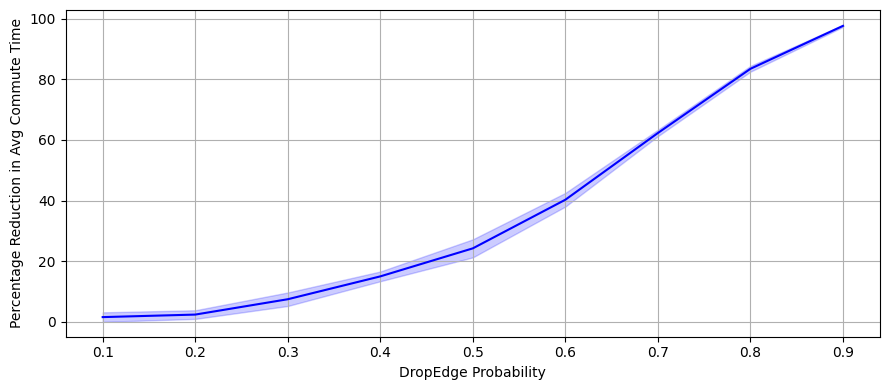

In [7]:
x, lower, means, upper = list(), list(), list(), list()

for i in range(len(keys)):
    p = keys[i]
    mean, std = map(lambda x: 100*x/no_drop_avg_commute_time, (no_drop_avg_commute_time-np.mean(avg_commute_times[p]), np.std(avg_commute_times[p])))
    x.append(p)
    lower.append(mean-std)
    means.append(mean)
    upper.append(mean+std)

plt.figure(figsize=(9,4))
plt.plot(x, means, color='blue')
plt.fill_between(x, lower, upper, alpha=0.2, color='blue')
plt.xlabel('DropEdge Probability')
plt.ylabel(f'Percentage Reduction in Avg Commute Time')
plt.grid()
plt.tight_layout()
plt.show()

# commute times computed over all node pairs, mean and std over DropEdge samples